In [1]:
import numpy as np
import pandas as pd
import random
import sklearn.preprocessing
import statsmodels.api as sm
from sklearn import datasets

import matplotlib.pyplot as plt
from tqdm import tqdm


## Step 0. 데이터 준비

In [2]:
# 출처 : https://www.kaggle.com/datasets/shivachandel/kc-house-data
data = pd.read_csv('data/Housesales/kc_house_data.csv')

In [3]:
X = data.drop(['price', 'date', 'id'], axis=1)
columns = dict(zip(list(range(len(X.columns))), X.columns))
X = sklearn.preprocessing.normalize(X, axis=1)
y = data['price']

In [4]:
X_selected = sm.add_constant(X)
model = sm.OLS(y, X_selected).fit()
score = model.rsquared_adj
score

0.6959337771808176

In [5]:
# from sklearn.datasets import load_diabetes

# diabetes = load_diabetes()
# df = pd.DataFrame(diabetes.data, columns=diabetes.feature_names)
# df["target"] = diabetes.target

In [6]:
# X = df.drop(['target'], axis=1)
# columns = dict(zip(list(range(len(X.columns))), X.columns))
# X = sklearn.preprocessing.normalize(X, axis=1)
# y = df['target']

In [7]:
# X_selected = sm.add_constant(X)
# model = sm.OLS(y, X_selected).fit()
# score = model.rsquared_adj
# score

## Step 1. 초기화

In [8]:
# Hyper Parameter
population_size = 8
cut_off = 0.8

In [9]:
def make_chromosome(X, population_size, cut_off):
    chromosome_list = []
    for chromosome in range(population_size):
        feature_random_number = []
        for feature in range(X.shape[1]):    
            if random.uniform(0,1) >= cut_off:
                feature_random_number.append(1)
            else:
                feature_random_number.append(0)
        chromosome_list.append(feature_random_number)
    return chromosome_list

In [10]:
chromosome_list = make_chromosome(X, population_size, cut_off)

## Step2. 모델 학습

In [11]:
def train_chromosome(X, chromosome_list, metric='adjusted_r_squared'):
    score_list = []
    for chromosome in range(population_size):
        indices = [i for i,x in enumerate(chromosome_list[chromosome]) if x == 1]
        X_selected = sm.add_constant(X[:,indices])
        model = sm.OLS(y, X_selected).fit()
        
        if metric == 'adjusted_r_squared': 
            score = model.rsquared_adj
        elif metric == 'rmse':
            score = np.sqrt(model.mse_resid)
        score_list.append(score)
    return score_list

In [12]:
score_list = train_chromosome(X, chromosome_list, metric='adjusted_r_squared')

## Step3. 적합도 평가

In [13]:
def evaluate_chromosome(score_list, chromosome_list, elitism = 1):
    seq = sorted(score_list, reverse=True) # adjusted_r_squared
#     seq = sorted(score_list) # rmse
    rank = [seq.index(v) for v in score_list]
    score_for_weight = score_list - min(score_list) # adjusted_r_squared
#     score_for_weight = max(score_list) - score_list # rmse
    sum_score = sum(score_for_weight)
    weight = [(score / sum_score) for score in score_for_weight]
    feature_num = [sum(i) for i in chromosome_list]
    eval_result = pd.DataFrame([score_list, rank, weight, feature_num]).T
    eval_result.columns = ['score', 'rank', 'weight', 'feature_num']
    eval_result['rank'] = eval_result.loc[:, ['rank']].astype('int')
    eval_result['feature_num'] = eval_result.loc[:, ['feature_num']].astype('int')
    
    if elitism:
        elite = eval_result.drop_duplicates().sort_values(['rank', 'feature_num']).index[:elitism*2]
    else:
        elite = False
        
    return eval_result, list(elite)

In [14]:
eval_result, elite = evaluate_chromosome(score_list, chromosome_list)

## Step4. 부모 염색체 선택

In [15]:
def select_parents(chromosome_list, eval_result):
    selected = np.random.choice(range(len(chromosome_list)), 2, p=eval_result['weight'], replace=False)
    parent_1, parent_2 = chromosome_list[selected[0]], chromosome_list[selected[1]]
    return parent_1, parent_2

In [16]:
parent_1, parent_2 = select_parents(chromosome_list, eval_result)

## Step5. 교배

In [17]:
crossover_num = 5
mutation_rate = 0.01

In [18]:
def crossover(parent_1, parent_2, crossover_num, mutation_rate):
    
    # make crossover point
    crossover_point = list(sorted(np.random.choice(range(1, len(parent_1)), crossover_num, replace=False)))
    crossover_point.append(len(parent_1))
    
    # split with crossover point
    parent_1_list = []
    parent_2_list = []
    for i, v in enumerate(crossover_point):
        if i == 0:
            parent_1_list.append(parent_1[:v])
            parent_2_list.append(parent_2[:v])
        else:
            parent_1_list.append(parent_1[crossover_point[i-1]:v])
            parent_2_list.append(parent_2[crossover_point[i-1]:v])
            
    # make new generations
    new_genes = []
    
    # crossover
    child_1, child_2 = [], []
    for j in range(crossover_num+1):
        p = random.uniform(0,1)
        if p <= 0.5 : 
            child_1 += parent_1_list[j]
            child_2 += parent_2_list[j]
        else:
            child_1 += parent_2_list[j]
            child_2 += parent_1_list[j]

    # mutation
    for k in range(len(child_1)):
        if random.uniform(0,1) <= mutation_rate:
            if child_1[k] == 0:
                child_1[k] = 1
            else:
                child_1[k] = 0

        if random.uniform(0,1) <= mutation_rate:
            if child_2[k] == 0:
                child_2[k] = 1
            else:
                child_2[k] = 0

    new_genes.append(child_1)
    new_genes.append(child_2)
        
    return new_genes

In [19]:
new_genes = crossover(parent_1, parent_2, crossover_num, mutation_rate)

## Run Algorithm

In [20]:
# Hyper Parameter
population_size = 32
cut_off = 0.7
crossover_num = 17
mutation_rate = 0.03
elitism = 1
metric = 'adjusted_r_squared'
early_stopping = 50

In [21]:
generation_num = 1000
stag = 0
best_score = 0
history = []
elite_history = []

for i in tqdm(range(generation_num)):
    if i == 0:
        chromosome_list = make_chromosome(X, population_size, cut_off)
    else:
        chromosome_list = child_list
    
    score_list = train_chromosome(X, chromosome_list, metric)
    eval_result, elite = evaluate_chromosome(score_list, chromosome_list, elitism)
    child_list = [chromosome_list[elite[i]] for i in range(elitism*2)]
    
    for i in range(int((population_size/2) - elitism)):
        parent_1, parent_2 = select_parents(chromosome_list, eval_result)
        new_genes = crossover(parent_1, parent_2, crossover_num, mutation_rate)
        child_list += new_genes
    
    history.append(max(score_list)) # r-squared
    elite_history.append(chromosome_list[elite[0]])
    
    if max(score_list) == best_score:
        stag += 1
    else:
        stag = 0

    best_score = history[-1]
        
    if stag == early_stopping:
        break
        

  7%|█████▎                                                                          | 67/1000 [00:15<03:38,  4.27it/s]


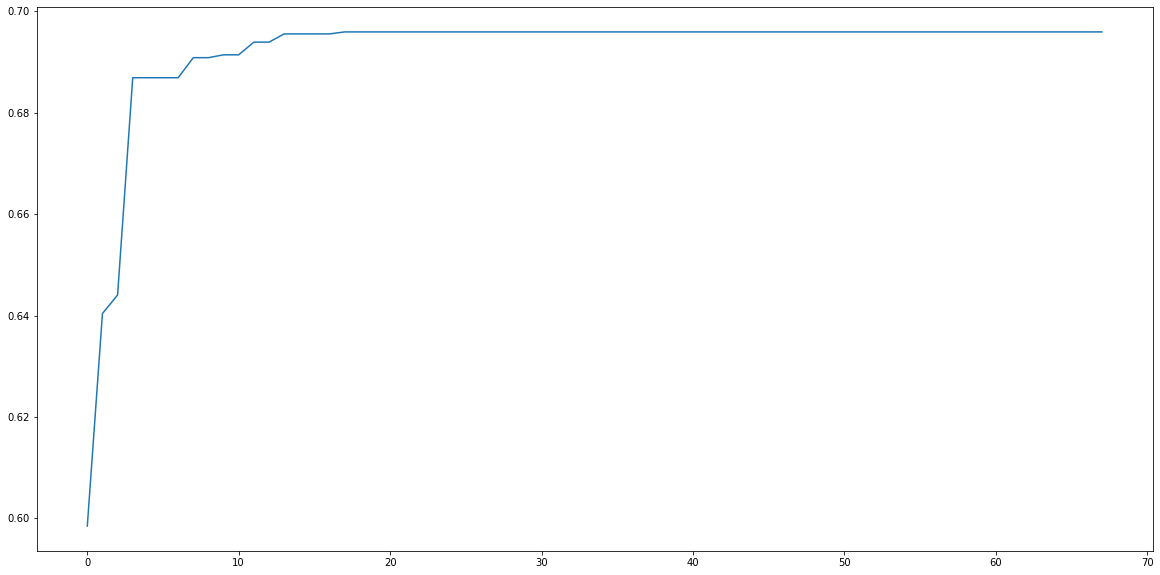

In [22]:
plt.figure(figsize=(20, 10))
plt.plot(history[0:])
plt.show()

In [ ]:
from model import genetic_algorithm
history, elite_history = genetic_algorithm(X, y, metric='rmse')

plt.figure(figsize=(20, 10))
plt.plot(history[0:])
plt.show()